# Data Challenge: Lukasz Przychodzien

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lprzy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
os.chdir('C:/Users/lprzy/Documents/takehome/quora-question-pairs')

In [4]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Exploratory Analysis of Training Data

Note: Add visualizations

In [5]:
#identifying any null values
df_train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
#Replace the empty questions with the word empty
df_train = df_train.fillna('empty')

In [7]:
#Each question has a unique id, and
#putting them together helps us identify repeated questions
allqid = list(df_train.qid1)+list(df_train.qid2)

In [13]:
#All of the question text into one variable
allq = pd.Series(df_train.question1.tolist() + df_train.question2.tolist()).astype(str)

In [92]:
#Total number of question pairs for training
len(df_train.id)

404290

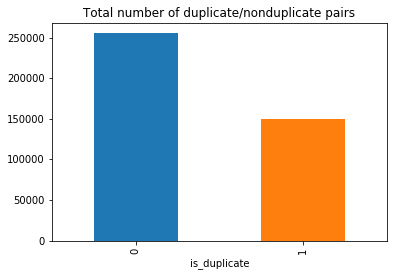

In [93]:
df_train.groupby("is_duplicate")['id'].count().plot.bar(title='Total number of duplicate/nonduplicate pairs')

In [94]:
#Percent of pairs that are duplicates
len(df_train[df_train.is_duplicate==1])/len(df_train.id)

0.369197853026293

In [7]:
#Total number of unique question
unique_elem, counts_elem = np.unique(allqid, return_counts=True)
len(unique_elem)

537933

In [98]:
#Total number of duplicate questions
np.sum(counts_elem > 1)

111780

In [99]:
#Percent of duplicate questions of total questions
np.sum(counts_elem > 1)/len(counts_elem)

0.20779539459375052

In [100]:
#Maximum number of times one question appears in the dataset
counts_elem.max()

157

In [102]:
#Total number of questions
len(allq)

808580

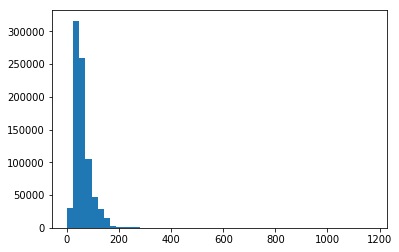

In [54]:
#Distribution of number of characters in questions
characters = allq.apply(lambda x: len(x)).tolist()
plt.hist(characters, bins=50)
plt.show()

In [55]:
#Maximum number of characters found in a question
max(characters)

1169

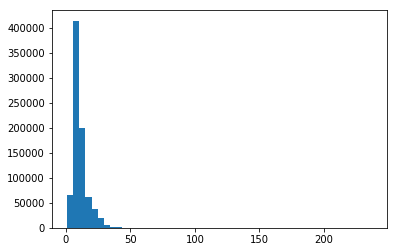

In [38]:
#Distribution of words of characters in questions
words = allq.apply(lambda x: len(x.split(' '))).tolist()
plt.hist(words, bins=50)
plt.show()

In [41]:
#Maxium number of words found in a question
max(words)

237

In [105]:
#Number of unqiue words in our corpus 
allq.apply(lambda x: len(x.split(' '))).nunique()

102

In [56]:
allq = allq.tolist()

# Cosine Similarity

We start with cosine similarity which measures the cosine of the angle between the two vectors formed by the two questions. 

## TF-IDF

We convert the words to vectors using term-frequency inverse document frequency.This will prepare the question vectors for cosine similarity.  

Here we will also use stemming to bring each word to its root form.

### Tokenize Questions

In [10]:
#Here we build out out count vectorizor with a stemming analyzer.

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

#Create our count vectorizers for word standardization
cvs = CountVectorizer(stop_words='english', analyzer=stemmed_words)

In [11]:
#learn the vocabulary of the questions
cvs.fit(allq)

CountVectorizer(analyzer=<function stemmed_words at 0x000001D0D0AC99D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [12]:
#Entire vocabulary and integer count of the number of times 
#each word appeared in all the questions (tokenized)

#Number of words on our vocabulary 
print(len(cvs.vocabulary_))

65362


In [57]:
#Example of some of the words in the vocabulary
list(cvs.vocabulary_.keys())[:10]

['what', 'is', 'the', 'step', 'by', 'guid', 'to', 'invest', 'in', 'share']

In [58]:
#Encode the questions based on the vocabulary. 
#Turning each question into a 0 padded term-document vector.
doc_cvs_matrix = cvs.transform(allq)

In [59]:
#The shape of our matrix which is the questions are encoded into seperate words
#(Documents,Words)
print(doc_cvs_matrix.shape)

(808580, 65362)


## Term Frequencies Transformation to TF-IDF

In [60]:
#Since we used CountVectorizer, we just use the Tf-IDF transformer 
from sklearn.feature_extraction.text import TfidfTransformer

In [61]:
#Create tf-idf transformer and fit the sparse matrix to generate the IDF
tf_transformer = TfidfTransformer()
tf_transformer.fit(doc_cvs_matrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [62]:
#Transform each question into a count matrix
cv_q1 = cvs.transform(df_train.question1)
cv_q2 = cvs.transform(df_train.question2)

In [63]:
#Transform each set of questions into a tf-idf vector representations
df_train_tfidf_q1 = tf_transformer.transform(cv_q1)
df_train_tfidf_q2 = tf_transformer.transform(cv_q1)

In [64]:
df_train_tfidf_q1.shape

(404290, 65362)

In [65]:
df_train_tfidf_q2.shape

(404290, 65362)

In [76]:
#Computer is not powerful to run all of the data, so taking top 10,000
dftq1 = df_train_tfidf_q1[:10000]
dftq2 = df_train_tfidf_q2[:10000]

In [77]:
#Define our X and y values for statistical modeling
#Returns the cosine of the angle between the two vectors into X
from sklearn.metrics.pairwise import cosine_similarity
Xcs = cosine_similarity(dftq1,dftq2)

In [80]:
#Our target values to predict become out y
y = df_train['is_duplicate'][:10000]

## Machine Learning Models using Cosine Similarity

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

In [81]:
#Split the training data into test and train data for our models
X_train, X_test, y_train, y_test = train_test_split(Xcs, y, test_size=0.3)

In [91]:
#Ensuring that the train data is split between dupliate/nonduplicate
print('Training duplicate percent: {:.2f}'.format(y_train[y_train==1].count()/len(y_train)))

Training duplicate percent: 0.37


In [92]:
#Ensuring that the test data is split between dupliate/nonduplicate
print('Testing duplicate percent: {:.2f}'.format(y_test[y_test==1].count()/len(y_test)))

Testing duplicate percent: 0.38


### Logistic Regression

In [93]:
lr = LogisticRegression()

In [94]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
#The predict_proba function returns probability of 0 and 1, respectively. 
#We need to only select the probability of 1 (same question)
pred_lr = lr.predict_proba(X_test)[:,1]

In [96]:
logloss_lr = log_loss(y_test, pred_lr)

In [97]:
logloss_lr

0.5925512108766888

In [98]:
y_pred_lr = lr.predict(X_test)

In [99]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
(tn, fp, fn, tp)

(1571, 300, 604, 525)

### Random Forest

In [100]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 2, max_features = 6, min_samples_split = 2, n_jobs = -1)

In [101]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
pred_rf = rf.predict_proba(X_test)[:,1]
logloss_rf = log_loss(y_test, pred_rf)

In [103]:
logloss_rf

0.5990682655159607

In [104]:
y_pred_rf = rf.predict(X_test)

In [105]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
(tn, fp, fn, tp)

(1616, 255, 698, 431)

### XGBoost

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [107]:
pred_xgb = xgb.predict_proba(X_test)[:,1]
logloss_xgb = log_loss(y_test, pred_xgb)

In [108]:
logloss_xgb

0.5895038258145757

In [109]:
y_pred_xgb = xgb.predict(X_test)

In [110]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
(tn, fp, fn, tp)

(1673, 198, 717, 412)

### Summary Using Cosine Similarity

We see that the cosine similarity performed a decent start with XGBoost performing best with a log loss of 0.5895. Compared to the kaggle winner with a log loss of 0.11, this is still very far off. 

Looking at the confusion matrix of each model, we want to prioritize the true positives (correctly identified duplicates) and reduce false positives (identified as duplicate when not). Therefore, XGBoost faired the best with the  lowest false positive count of 198, but the worst true positive rate. From a customer experience perspective, however, false positives are arguably worse. 

# Jaccard Similarity

Moving to Jaccard Similarity allows us to classify our similaity by the size of each question pair's intersection. 

### Lemmatization

Reducing our words to the same canonical form of each word to most accurately compare characters. 

In [141]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [178]:
def jaccard_sim(str1, str2): 
    a = set(lemmatizer.lemmatize(w) for w in str1.lower().split()) 
    b = set(lemmatizer.lemmatize(w) for w in str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [182]:
df_train_samp = df_train[:10000].copy()

In [183]:
df_train_samp['Xjs'] = df_train_samp.apply(lambda x: jaccard_sim(x.question1,x.question2),axis=1)

In [185]:
#Define our X and y values for statistical modeling
Xjs = df_train_samp.Xjs
y = df_train_samp.is_duplicate

## Machine Learning Models using Jaccard Similarity

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

In [197]:
#Split the training data into test and train data for our models
X_train, X_test, y_train, y_test = train_test_split(Xjs, y, test_size=0.3)

In [198]:
#Ensuring that the train data is split between dupliate/nonduplicate
y_train[y_train==1].count()/len(y_train)

0.37142857142857144

In [199]:
#Ensuring that the test data is split between dupliate/nonduplicate
y_test[y_test==1].count()/len(y_test)

0.37033333333333335

### Logistic Regression

In [200]:
lr = LogisticRegression()

In [201]:
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

In [202]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [203]:
#The predict_proba function returns probability of 0 and 1, respectively. 
#We need to only select the probability of 1 (same question)
pred_lr = lr.predict_proba(X_test)[:,1]

In [204]:
logloss_lr = log_loss(y_test, pred_lr)

In [205]:
logloss_lr

0.5988621825312884

In [206]:
y_pred_lr = lr.predict(X_test)

In [207]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
(tn, fp, fn, tp)

(1608, 281, 798, 313)

### XGBoost

In [210]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [211]:
pred_xgb = xgb.predict_proba(X_test)[:,1]
logloss_xgb = log_loss(y_test, pred_xgb)

In [212]:
logloss_xgb

0.5381118700002083

In [213]:
y_pred_xgb = xgb.predict(X_test)

In [214]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
(tn, fp, fn, tp)

(1300, 589, 333, 778)

### Summary Using Cosine Similarity

We see that the Jaccard similarity performed better than cosine similarity with XGBoost performing best with a log loss of 0.538. Random Forest was not used since we are using a 1D array.  

Looking at the confusion matrix of each model, we want to prioritize the true positives (correctly identified duplicates) and reduce false positives (identified as duplicate when not). Therefore, XGBoost faired the best with the  lowest false positive count of 281, but the worst true positive rate. From a customer experience perspective, however, false positives are arguably worse. 

# Conclusion

Even though our Jaccard similarity models performed with a lower log loss, the cosine similairy XGBoost model best satisfied the question with the lowest false positive count vs true positive count. 